In [2]:
import networkx as nx
from parso.python.tokenize import group


class compartment:
    def __init__(self):
        self.out_flow_rate_limit: float = None
        self.in_flow_rate_limit: float = None
        self.storage_capacity_in_limit: float = None
        self.capacity:float = None
        self.storage_capacity_out_limit: float = None

        self.storage_out: float = 0
        self.storage_in: float = 0
        self.production_duration: float = None

class super_compartment(compartment):
    def __init__(self, name=None,  sub_compartments: compartment = None):
        self.name = name
        self.sub_compartments: nx.Graph = sub_compartments
        self.lever=1



class work_compartment(compartment):
    def __init__(self, name=None):
        self.name = name
        self.lever=2
        self.work_step_duration: float = None

class connector_component(compartment):
    def __init__(self, name=None, connecting=None, flow_limit=100):
        self.name = name
        self.lever=3
        self.connecting= connecting
        self.flow_limit=flow_limit
        self.work_step_duration: float = None


class factory(super_compartment):
    def __init__(self, name=None,  sub_compartments: compartment = None):
        self.name = name
        self.sub_compartments: nx.Graph = sub_compartments
        self.lever=0

    def to_graph(self):
        g = nx.Graph()
        g.add_node(self, name=self.name, degree=2-self.lever)
        ln=self
        for n in self.sub_compartments:
            g.add_node(n, name=n.name, degree=2-n.lever)
            g.add_edge(ln, n)
            ln=n

        lc = None
        for c in p.sub_compartments:
            g.add_edge(c, c.sub_compartments[0], type=0)
            for c2 in c.sub_compartments:
                g.add_node(c2, name=c2.name, degree=2-c2.lever)
                if lc is not None:
                    g.add_edge(lc, c2, type=1)
                lc = c2
        return g


In [3]:
w1 = work_compartment("Fermenter 80L")
w1.volume = 80

w2 = work_compartment("Fermenter 400L")
w2.volume = 400

w3 = work_compartment("Fermenter 2000L")
w3.volume = 2000

w4 = work_compartment("Fermenter 12000L")
w4.volume = 12000

p1 = connector_component("Pipe1", connecting=(w1, w2), flow_limit=100)
p2 = connector_component("Pipe2", connecting=(w2, w3), flow_limit=100)
p3 = connector_component("Pipe3", connecting=(w3, w4), flow_limit=100)

w5 = work_compartment("Capture Column")
w6 = work_compartment("KEX Column")
w7 = work_compartment("AEX Column")
w8 = work_compartment("UF/DF")
w9 = work_compartment("Storage Product")

p4 = connector_component("Pipe4", connecting=(w4, w5), flow_limit=100)
p5 = connector_component("Pipe5", connecting=(w5, w6), flow_limit=100)
p6 = connector_component("Pipe6", connecting=(w6, w7), flow_limit=100)
p7 = connector_component("Pipe7", connecting=(w7, w8), flow_limit=100)
p8 = connector_component("Pipe8", connecting=(w8, w9), flow_limit=100)


upstream = super_compartment(name="upstream", sub_compartments=[w1,w2,w3,w4])
downstream = super_compartment(name="downstream", sub_compartments=[w5,w6,w7])
formulation = super_compartment(name="formulation", sub_compartments=[w8, w9])

p = factory(name="myplant", sub_compartments=[upstream, downstream, formulation])




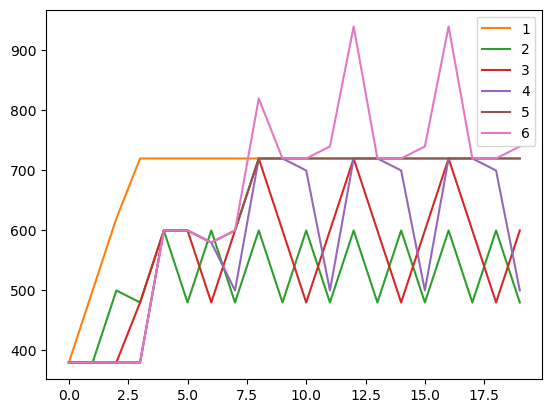

In [185]:
import ipycytoscape

undirected = ipycytoscape.CytoscapeWidget(p.to_graph())


undirected.set_style(
    [
        {
             'selector': 'node',
             'style': {
                 'font-family': 'helvetica',
                 'font-size': '20px',
                 'label': 'data(name)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'font-family': 'helvetica',
                 'font-size': '20px'
             }
        },
        {
             'selector': 'edge[type = 1]',
             'style': {
                 'font-family': 'helvetica',
                 'font-size': '20px',
                 "line-color": "red",
                 "target-arrow-color": "green",
                 "curve-style": "bezier",
                 "target-arrow-shape": "triangle",   # arrow at target end
             }
        },
        {
             'selector': 'node[degree>0]',
             'style': {
                 'width': '100px',
                 'height': '100px',
                 "shape": "triangle",
             }
        },
        {
             'selector': 'node[degree>1]',
             'style': {
                 'width': '150px',
                 'height': '150px',
                  "shape": "rectangle",
             }
        },
        {
             'selector': 'node[degree>2]',
             'style': {
                 'width': '200px',
                 'height': '200px',
             }
        }
    ]
)

undirected.set_layout(
    name='cose',   # Options: 'grid', 'circle', 'concentric', 'breadthfirst', 'cose', etc.
    animate=True,  # Animate the transition
    randomize=True # Randomize initial positions
)

undirected

In [4]:
#process step:
def requires(min_V):
    def check_volume(vessel):
        return vessel.volume >= min_V
        
#Integrate:
class procedure:
    def __init__(self, name=None, equipment_requirement=None):
        self.name = name

class fill_procedure:
    def __init__(self, name=None, flow=5, target_volume=40, equipment_requirement=None):
        self.name = name
        self.flow = flow
        self.target_volume= target_volume

        self.equipment_requirement = [requires(target_volume)]

class incubation_procedure:
    def __init__(self, name=None, incubation_time=20, equipment_requirement=None):
        self.name = name
        self.incubation_time = incubation_time




#80L Tank
fill_w1 = fill_procedure("Fill 80L", flow=5, target_volume=75)
incubate_w1 = incubation_procedure("Incubate 80L", incubation_time=20,)
empty_w1 = fill_procedure("Empty 80L", flow=-5, target_volume=0)

procedure_list_w1 = [fill_w1, incubate_w1, empty_w1]

#400L Tank
fill_w2 = fill_procedure("Fill 400L", flow=5, target_volume=375)
incubate_w2 = incubation_procedure("Incubate 400L", incubation_time=60)
empty_w2 = fill_procedure("Empty 400L", flow=-5, target_volume=0)

procedure_list_w2 = [fill_w2, incubate_w2, empty_w2]



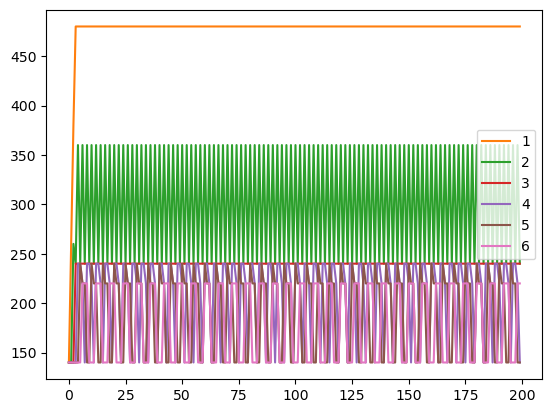

In [166]:
for p in procedure_list_w1:
    print(p.name)
    
    

In [224]:
import simpy as sim
import numpy as np
import pandas as pd


class Vessel(sim.Container):
    def __init__(self, env, init=0, capacity=250, incubation_time=19, resource=None):
        super().__init__(env=env, init=init, capacity=capacity)
        self.incubation_time = incubation_time
        self.env = env
        self.request = None
        self.resource = resource
        self.in_use = False

    def activate_resource(self):
        self.request = self.resource.request()
        self.in_use = True
        return self.request

    def release_resource(self):
        self.resource.release(self.request)
        self.in_use = False

    def produce(self, runID=None):
        yield self.env.timeout(self.incubation_time)

    def transfer(self, target_vessel, dv=-1):
        if dv < 0:
            tv = self.level
        else:
            tv = dv
        self.get(tv)
        target_vessel.put(tv)


class factory(object):  # Equipment
    def __init__(self, env, num_ferm_stage1=4, num_ferm_stage2=2,
                 num_ferm_stage3=2, num_ferm_stage4=6, num_harvester=1):
        self.env = env
        self.ferm_stage1 = sim.Resource(env, capacity=num_ferm_stage1)
        self.ferm_stage1.get_vessel = lambda : Vessel(env, init=0, capacity=60, incubation_time=20, resource=self.ferm_stage1)
        self.ferm_stage2 = sim.Resource(env, capacity=num_ferm_stage2)
        self.ferm_stage2.get_vessel = lambda : Vessel(env, init=0, capacity=250, incubation_time=120, resource=self.ferm_stage2)
        self.ferm_stage3 = sim.Resource(env, capacity=num_ferm_stage3)
        self.ferm_stage3.get_vessel = lambda : Vessel(env, init=0, capacity=3000, incubation_time=240, resource=self.ferm_stage3)
        self.ferm_stage4 = sim.Resource(env, capacity=num_ferm_stage4)
        self.ferm_stage4.get_vessel = lambda : Vessel(env, init=0, capacity=14000, incubation_time=1000, resource=self.ferm_stage4)
        self.harvester = sim.Resource(env, capacity=num_harvester)
        self.harvester.get_vessel = lambda : Vessel(env, init=0, capacity=500, incubation_time=100, resource=self.harvester)
        self.stats = None



In [240]:
    # Process Modell
    def campaignA(env, runID, plant:factory): # Process Control
        yield env.process(upstream(env, runID, plant))


    def upstream(env, runID, plant):
        #Stage 1
        ## Init
        active_vessel_stage1 = plant.ferm_stage1.get_vessel()
        yield active_vessel_stage1.activate_resource()


        ## prod1
        start_time = env.now
        yield env.process(active_vessel_stage1.produce(runID))
        end_time_s1 = env.now

        #Stage 2
        active_vessel_stage2 = plant.ferm_stage2.get_vessel()
        yield active_vessel_stage2.activate_resource()
        active_vessel_stage1.release_resource()

        start_time_s2 = env.now
        yield env.process(active_vessel_stage2.produce(runID))
        end_time_s2 = env.now

        #Stage 3
        active_vessel_stage3 = plant.ferm_stage3.get_vessel()
        yield active_vessel_stage3.activate_resource()
        active_vessel_stage2.release_resource()

        start_time_s3 = env.now
        yield env.process(active_vessel_stage3.produce(runID))
        end_time_s3 = env.now

        #Stage 4
        active_vessel_stage4 = plant.ferm_stage4.get_vessel()
        yield active_vessel_stage4.activate_resource()
        active_vessel_stage3.release_resource()

        start_time_s4 = env.now
        yield env.process(active_vessel_stage4.produce(runID))
        end_time_s4 = env.now

        #Harvest
        active_harvester = plant.harvester.get_vessel()
        yield active_harvester.activate_resource()
        active_vessel_stage4.release_resource()

        start_time_h = env.now
        yield env.process(active_harvester.produce(runID))
        end_time_h = env.now
        active_harvester.release_resource()

        # Post Analysis
        end_time= env.now
        duration = end_time - start_time
        duration_s1 = end_time_s1 - start_time
        duration_s2 = end_time_s2 - start_time_s2
        duration_s3 = end_time_s3 - start_time_s3
        duration_s4 = end_time_s4 - start_time_s4
        duration_h = end_time_h - start_time_h

        res_dict= {
                    "run":runID, "campaign_type": "CampaignA", "campaign_duration": duration,
                    "start_campaign": start_time, "end_campaign": end_time, "duration_campaign":duration,
                    "stage1_start": start_time, "stage1_end": end_time_s1, "stage1_duration": duration_s1,
                    "stage2_start": start_time_s2, "stage2_end": end_time_s2, "stage2_duration": duration_s2,
                    "stage3_start": start_time_s3, "stage3_end": end_time_s3, "stage3_duration": duration_s3,
                    "stage4_start": start_time_s4, "stage4_end": end_time_s4, "stage4_duration": duration_s4,
                    "harvest_start": start_time_h, "harvest_end": end_time_h, "harvest_duration": duration_h,
                    }
        env.prod_durations.append(res_dict)



In [241]:
import time
def run_campaign_on_factory(env, campaign, plant:factory, num_runs=10): #Simulation Control
    for run in range(num_runs):
        env.process(campaign(env, run, plant))
        yield env.timeout(0)  # Wait a bit before generating a new person

# Run simulation:
dfs_list = []
for i in range(1,6):
    print(i)
    env = sim.Environment()
    env.prod_durations = []

    # Plant Modell
    plant = factory(env=env,
                    num_ferm_stage1=4, num_ferm_stage2=i, num_ferm_stage3=i, num_ferm_stage4=i*2,
                    num_harvester=i)

    # Simulation
    simulation = run_campaign_on_factory(env=env, campaign=campaignA,
                                         plant=plant, num_runs=20)
    env.process(simulation)
    env.run()

    # Results
    df = pd.DataFrame(env.prod_durations)
    df['num_stage3'] = i
    dfs_list.append(df)

dfs=pd.concat(dfs_list, ignore_index=True)

1
2
3
4
5


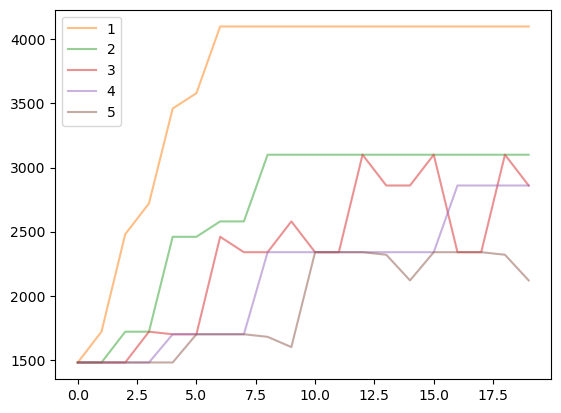

In [242]:
from matplotlib import pyplot as plt

for i in dfs["num_stage3"].unique():
    sub_df = dfs.loc[dfs["num_stage3"] == i]
    plt.plot(sub_df["run"], sub_df["duration_campaign"], c=f"C{i}", label=i, alpha=0.5)

plt.legend()

#plt.ylim([350, 500])